# Day 08. Exercise 05
# Clustering

## 0. Imports

In [448]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score

## 1. Preprocessing

1. Read the file [`regression.csv`](https://drive.google.com/file/d/1fzOPkuXoxLleOsvNVCT0m-LKxlid33ma/view?usp=sharing) to a dataframe.
2. Remove the `pageviews`, we will cluster the users only by the number of the commits and their average difference.

In [449]:
df = pd.read_csv('../data/regression.csv')
df.drop(columns=['pageviews'], inplace=True)

X = df[['num_commits', 'AVG(diff)']].copy()

# scaler = StandardScaler()
# X = scaler.fit_transform(X)

## 2. KMeans

1. Check the documentation about how this algorithm works.
2. Use this algorithm to create clusters, use `random_state=21` and `n_clusters=3`.
3. Visualize the data on a `scatter plot`.
4. Try different values of `n_clusters` and see how your plot will change.
5. Calculate the `silhouette_score` (check the docs about the metric).

In [450]:
kmeans = KMeans(n_clusters=3, random_state=21, n_init='auto')
labels = kmeans.fit_predict(X)

df_km = df.copy()
df_km['cluster'] = labels

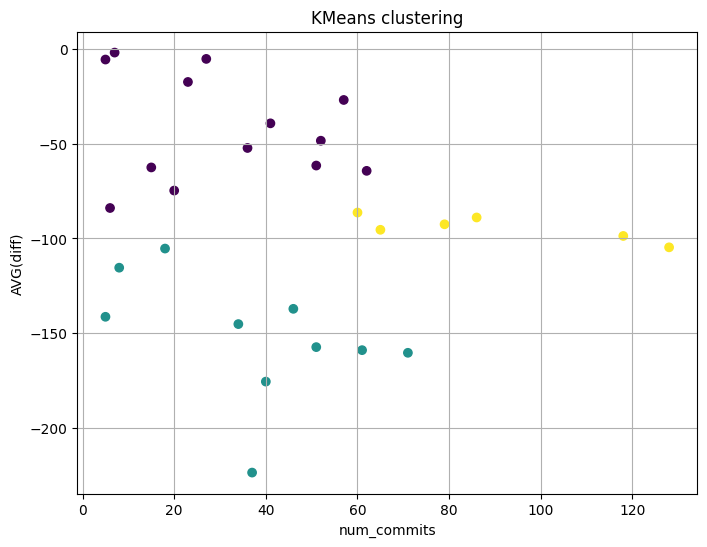

In [451]:
plt.figure(figsize=(8, 6))
plt.scatter(df_km['num_commits'], df_km['AVG(diff)'], c=df_km['cluster'])

plt.xlabel('num_commits')
plt.ylabel('AVG(diff)')
plt.title('KMeans clustering')
plt.grid(True)
plt.show()

In [452]:
best = {}
for k in range(2, 12):
    km = KMeans(n_clusters=k, random_state=21, n_init='auto')
    lab = km.fit_predict(X)
    best[k] = silhouette_score(X, lab)

best_k, best_score = max(best.items(), key=lambda x: x[1])
print(f"best k = {best_k}, silhouette = {best_score}")

best k = 8, silhouette = 0.48638087320227846


## 3. DBSCAN

1. Check the documentation about how this algorithm works.
2. Use this algorithm to create clusters with `eps=20` and `min_samples=2`.
3. Visualize the data on a `scatter plot`.
4. Try different values of `eps` and `min_samples` and see how your plot will change.
5. Calculate the `silhouette_score` (check the docs about the metric).

In [453]:
db = DBSCAN(eps=20, min_samples=2)
labels = db.fit_predict(X)

df_db = df.copy()
df_db['cluster'] = labels

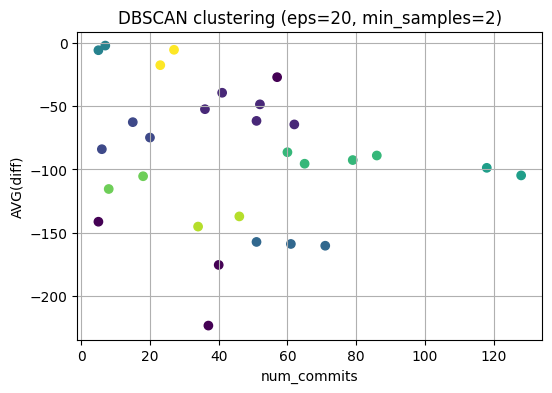

In [454]:
plt.figure(figsize=(6, 4))
plt.scatter(df_db['num_commits'], df_db['AVG(diff)'], c=df_db['cluster'])

plt.xlabel('num_commits')
plt.ylabel('AVG(diff)')
plt.title('DBSCAN clustering (eps=20, min_samples=2)')
plt.grid(True)
plt.show()

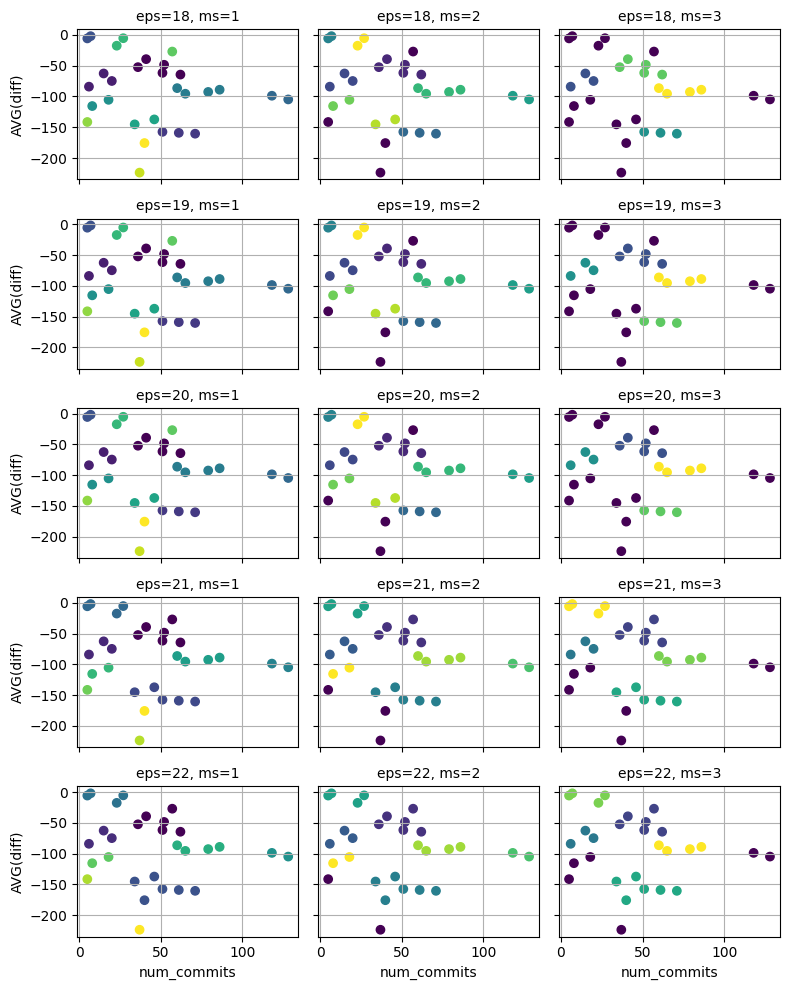

In [455]:
eps_values = range(18,23)
min_samples_values = range(1,4)

n_rows = len(eps_values)
n_cols = len(min_samples_values)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(8, 10), sharex=True, sharey=True)

for i, eps in enumerate(eps_values):
    for j, ms in enumerate(min_samples_values):
        db = DBSCAN(eps=eps, min_samples=ms)
        labels = db.fit_predict(X)

        ax = axes[i, j]
        ax.scatter(df['num_commits'], df['AVG(diff)'], c=labels)

        ax.set_title(f"eps={eps}, ms={ms}", fontsize=10)
        ax.grid(True)

        if i == n_rows - 1:
            ax.set_xlabel("num_commits")
        if j == 0:
            ax.set_ylabel("AVG(diff)")

plt.tight_layout()
plt.show()

In [456]:
best_score = -1
best_params = None

eps_grid = range(5, 51)
min_samples_grid = range(1, 6)

for eps in eps_grid:
    for ms in min_samples_grid:
        db = DBSCAN(eps=eps, min_samples=ms)
        labels = db.fit_predict(X)

        mask = labels != -1
        labels_clean = labels[mask]

        n_clusters = len(set(labels_clean))
        if n_clusters < 2:
            continue

        score = silhouette_score(X[mask], labels_clean)

        if score > best_score:
            best_score = score
            best_params = (eps, ms)

print("best eps, min_samples =", best_params)
print("best silhouette (without noise) =", best_score)

best eps, min_samples = (8, 2)
best silhouette (without noise) = 0.9480226534673492


## 4. Hierarchical (AgglomerativeClustering)

1. Use this algorithm to create clusters with `n_clusters=5`.
2. Visualize the data on a `scatter plot`.
3. Try different values of `n_clusters` and see how your plot will change.
4. Calculate the `silhouette_score`.
5. Visualize the `dendrogram`.

In [457]:
agg5 = AgglomerativeClustering(n_clusters=5, linkage='ward')
labels_5 = agg5.fit_predict(X)

df_h = df.copy()
df_h['cluster'] = labels_5

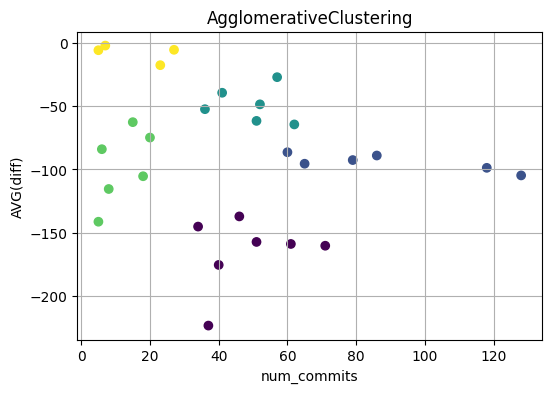

silhouette_score: 0.46383015199381467


In [458]:
plt.figure(figsize=(6, 4))
plt.scatter(df_h['num_commits'], df_h['AVG(diff)'], c=df_h['cluster'])
plt.xlabel('num_commits')
plt.ylabel('AVG(diff)')
plt.title('AgglomerativeClustering')
plt.grid(True)
plt.show()

print("silhouette_score:", silhouette_score(X, labels_5))

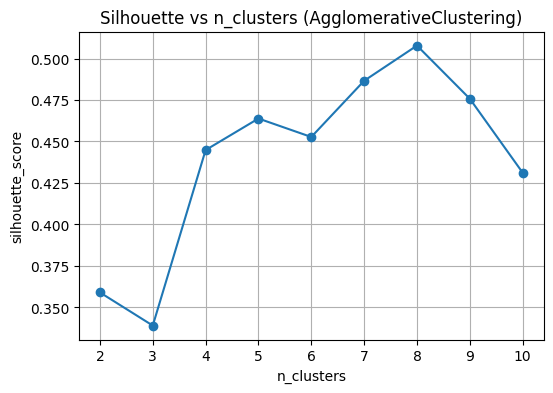

best n_clusters in this range: 8


In [459]:
ks = range(2, 11)
scores = []

for k in ks:
    lab = AgglomerativeClustering(n_clusters=k, linkage='ward').fit_predict(X)
    scores.append(silhouette_score(X, lab))

plt.figure(figsize=(6, 4))
plt.plot(list(ks), scores, marker='o')
plt.xlabel('n_clusters')
plt.ylabel('silhouette_score')
plt.title('Silhouette vs n_clusters (AgglomerativeClustering)')
plt.grid(True)
plt.show()

best_k = list(ks)[int(np.argmax(scores))]
print("best n_clusters in this range:", best_k)

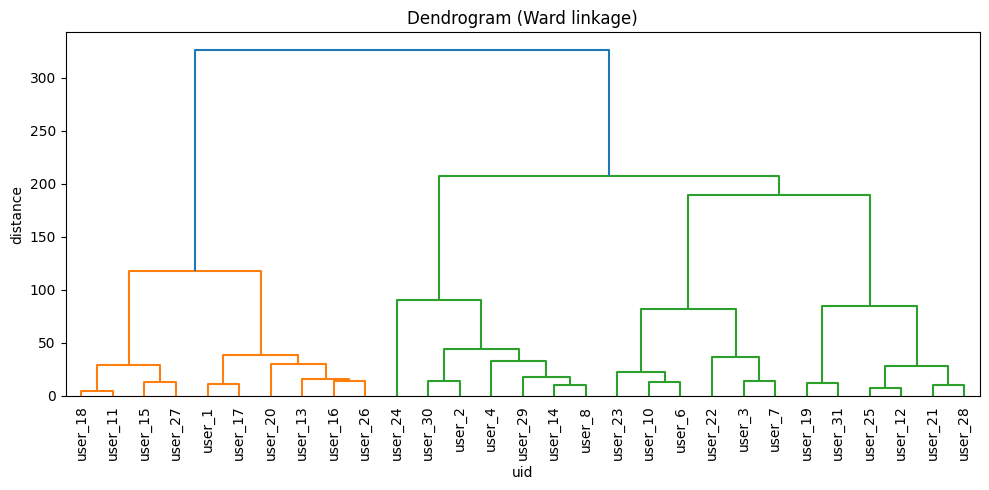

In [460]:
Z = linkage(X, method='ward')

plt.figure(figsize=(10, 5))
dendrogram(Z, labels=df['uid'].astype(str).values)
plt.title('Dendrogram (Ward linkage)')
plt.xlabel('uid')
plt.ylabel('distance')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


## 5. Function

Write a function that:
1. Takes as arguments: model class of clustering, its parameters, the name of the parameter for optimization, the range of the parameter values to try.
2. Tries different values from the given parameter range and calculates the `silhouette_score` for each value from the range.
3. Finds out the best value for the parameter in the range.
4. Returns two subplots:


- - the first shows how the `silhouette_score` changes depending on the value of the parameter,
- - the second visualizes the data on a `scatter plot` using the clustering model with the best value of the parameter.

In [461]:
def tune_clustering_param(
    model_cls,
    model_params: dict,
    param_name: str,
    param_values,
    X: pd.DataFrame,
    *,
    scale: bool = True,
    plot_cols=('num_commits', 'AVG(diff)'),
):
    X_in = X.copy()
    X_fit = StandardScaler().fit_transform(X_in) if scale else X_in.values

    values = list(param_values)
    scores = []

    for v in values:
        params = dict(model_params)
        params[param_name] = v

        labels = model_cls(**params).fit_predict(X_fit)

        if len(set(labels)) < 2:
            scores.append(np.nan)
        else:
            scores.append(silhouette_score(X_fit, labels))

    best_idx = int(np.nanargmax(scores))
    best_value = values[best_idx]

    best_params = dict(model_params)
    best_params[param_name] = best_value
    best_labels = model_cls(**best_params).fit_predict(X_fit)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(values, scores, marker='o')
    ax1.set_title(f"Silhouette vs {param_name}")
    ax1.set_xlabel(param_name)
    ax1.set_ylabel("silhouette_score")
    ax1.grid(True)

    x_col, y_col = plot_cols
    ax2.scatter(X_in[x_col], X_in[y_col], c=best_labels)
    ax2.set_title(f"Best {param_name} = {best_value}")
    ax2.set_xlabel(x_col)
    ax2.set_ylabel(y_col)
    ax2.grid(True)

    plt.tight_layout()
    return fig, (ax1, ax2), best_value, scores

Best n_clusters: 6


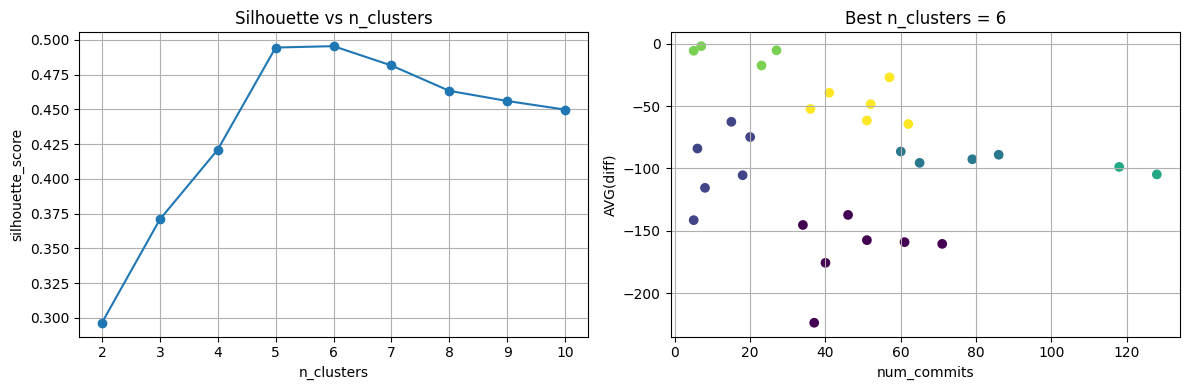

In [462]:
X = df[['num_commits', 'AVG(diff)']].copy()

fig, axes, best_k, scores = tune_clustering_param(
    AgglomerativeClustering,
    model_params={'linkage': 'ward'},
    param_name='n_clusters',
    param_values=range(2, 11),
    X=X,
    scale=True
)

print("Best n_clusters:", best_k)